# Multi-Armed Bandits

## Exponential Thompson Sampling (ExpTS)

Exponential Thompson Sampling (ExpTS) is a Bayesian algorithm for solving multi-armed bandit problems with exponential rewards. "We present a general variant of Thompson sampling for exponential family rewards in Algorithm 1, which is termed ExpTS. At round t, ExpTS maintains an estimate of a sampling distribution for each arm, denoted as P. The algorithm generates a sample parameter $θ_i(t)$ for each arm $i$ independently from their sampling distribution and chooses the arm that attains the largest sample parameter. For each arm $i ∈ [K]$, the sampling distribution P is usually defined as a function of the total number of pulls $T_i(t)$ and the empirical average reward $\hat{μ}_i(t)$. After pulling the chosen arm, the algorithm updates $T_i(t)$ and $\hat{μ}_i(t)$ for each arm based on the reward rt it receives and proceeds to the next round.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy.stats import expon

C:\Users\slm\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
class Bandit:
    def __init__(self, num_arms, beta_vals=None):
        # Set the random seed for reproducibility
        np.random.seed(seed=7)
        # Store the number of arms
        self.num_arms = num_arms
        # Define a small positive constant to avoid division by zero errors
        epsilon = 1e-6
        # Initialize the beta values for each arm
        if beta_vals is None:
            # If no beta values are provided, sample them randomly from a uniform distribution on [epsilon, 1]
            self.beta_vals = np.random.uniform(epsilon, 1, num_arms)
        else:
            # If beta values are provided
            self.beta_vals = beta_vals
        # Initialize arrays to store the total reward and number of pulls for each arm
        self.S = np.zeros(num_arms)
        self.F = np.zeros(num_arms)
    
    def pull_arm(self, arm_index):
        # Sample a reward from an exponential distribution with rate beta_vals[arm_index]
        reward = np.random.exponential(self.beta_vals[arm_index])
        # Return the sampled reward
        return reward

In [39]:
'''
Old KL function, works %2.2 slower
def KL(X, Y):
    f = lambda x: X.pdf(x) * (np.log(X.pdf(x)/Y.pdf(x)))
    return quad(f, -np.inf, np.inf)[0]
'''
def KL(X, Y):
    # Define the integrand function for the KL divergence
    f = lambda x: -X.pdf(x)*(Y.logpdf(x) - X.logpdf(x))
    # Compute the definite integral of the integrand from -inf to inf
    return quad(f, -np.inf, np.inf)[0]

def solve_X(mu, result):
    # Create an exponential distribution object with rate mu
    X = expon(scale=1/mu)
    # Define a function to find the root of
    def f(x):
        # Create an exponential distribution object with rate x
        Y = expon(scale=1/x)
        # Compute the difference between the KL divergence and the target result (result - kl = 0)
        return KL(X, Y) - result
    # Use fsolve to find the root of the function f
    x = fsolve(f, mu)
    return x[0]

def sample_theta(mu, n):
    # when n - 1 = 0, prevent divide by zero by setting result to 0 
    if n == 1: result = 0
    else:
        # Sample a random value y from a uniform distribution on [0, 1]
        y = np.random.uniform(0, 1)
        if y >= 0.5:
            # Compute the target result for KL(mu, x) using y (y>=1/2) and n
            result = np.log(1 / (2 * (1 - y))) / (n - 1)
        else:
            # Compute the target result for KL(mu, x) using y (y<1/2) and n
            result = np.log(1 / (2 * y)) / (n - 1)
    # Solve for x using the solve_X function
    x = solve_X(mu, result)
    return x

def exponential_thompson_sampling(num_arms, num_episodes, beta=None):
    # Create a bandit object with the given number of arms and beta values
    bandit = Bandit(num_arms, beta)
    # Initialize an array to store the theta values for each arm with 0s
    theta_values = [0.0] * num_arms
    sequence_pulls = []
    reward_round = []
    
    # Loop over the episodes
    for t in range(1, num_episodes + 1):
        # Exploration: Play each arm once
        if t < num_arms + 1:
            # Select the current arm as the action
            action = t - 1
            # Pull the selected arm and observe the reward
            reward = bandit.pull_arm(action)
            # Update the total reward and number of pulls for the selected arm
            bandit.S[action] += reward
            bandit.F[action] += 1
        else:
            # Exploitation: Select the arm with the highest sampled theta valu
            for i in range(num_arms):
                # Compute the mean reward (mu_i) and number of pulls (n_i) for arm i
                mu_i = bandit.S[i] / bandit.F[i]
                n_i = bandit.F[i]
                # Sample θi(t) independently from P(̂μi(t), Ti(t))
                theta_values[i] = sample_theta(mu_i, n_i)
            print(theta_values)
            # Select the arm with the highest sampled theta value as the action
            action = np.argmax(theta_values)
            # Pull the selected arm and observe the reward
            reward = bandit.pull_arm(action)
            # Update the total reward and the number of pulls
            bandit.S[action] += reward
            bandit.F[action] += 1
        # Store the selected action and observed reward in the sequence arrays
        sequence_pulls.append(action)
        reward_round.append(reward)

    # Return the sequence of arm pulls and average rewards per arm
    return sequence_pulls, reward_round

In [9]:
def singleGraph(num_arms, num_episodes, sequence_pulls, reward_round):
    x = np.arange(1, num_episodes+1)
    y = reward_round
    z = sequence_pulls
    df = pd.DataFrame({'x':x, 'y':y, 'z':z})
    groups = df.groupby('z')
    for name, group in groups:
        plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)
        
    # Plotting the Round Number vs. Reward
    plt.xlabel('Round Number')
    plt.ylabel('Reward')
    plt.title('Reward vs. Round Number')
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.show()
    
    cumulative_reward = np.cumsum(reward_round)
    plt.xlabel('Round')
    plt.ylabel('Cumulative Reward')
    plt.plot(cumulative_reward)
    plt.show()

C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':
C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # This is added back by InteractiveShellApp.init_path()


[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 3.243800780025824, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 1.9174414045817416, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 1.3668570856643212, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 1.266761882937572, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 1.0949338412026608, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 1.0283348214566486, 0.9605948009369021, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 0.6101741304280051, 0.9605948009369021, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639811738684, 0.6101741304280051, 0.8264287277204285, 0.69593784920057]
[0.0158753819042889, 0.454127602367636, 0.43273639

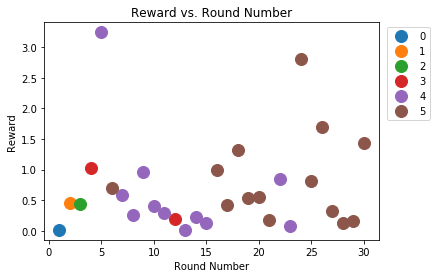

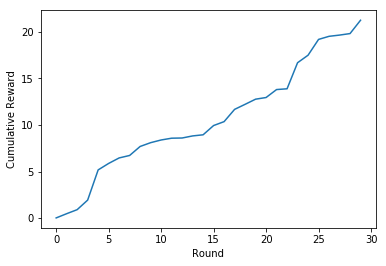

In [40]:
_beta = [0.2, 0.3, 0.75, 0.8, 0.85, 0.9]
num_arms = 6
num_episodes = 30
import time
start = time.time()
s6, r6 = exponential_thompson_sampling(num_arms, num_episodes, _beta)
end = time.time()
print(end - start)
singleGraph(num_arms, num_episodes, s6, r6)